In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use("ggplot")
%matplotlib inline
import glob

import sys
sys.version

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


'3.5.3 |Anaconda custom (64-bit)| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]'

# 创建所需要的函数

In [68]:
class Models():
    
    def __init__(self):
        print ("Creating ML_Models...")
    ####### Model 1: random_forest #######
    
    # para_1: m_d = max_depth,
    # para_2: m_s_s = min_samples_split,
    # para_3: n_e = n_estimators,
    # para_4: rs = random_state
    def random_forest(self, m_d, m_s_s, n_e, rs):
        rf_model = RandomForestClassifier(
                        max_depth=m_d,
                        min_samples_split=m_s_s,
                        n_estimators=n_e,
                        random_state=rs)
        return rf_model
    
    ####### Model 2: SVM #######
    
    # para_1: C = C,
    # para_2: gamma = gamma,
    # para_3: svm_rs = random_state
    def svm(self, C, gamma, svm_rs):
        svm_model = SVC(C = C, 
                        gamma = gamma, 
                        random_state = svm_rs)
        return svm_model
    

def preprocess_df(location, file):
    df = pd.read_csv(location+file, engine="python", header=None)
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'open_interests']
    return df

def preprocess_df_multiplies(file):
    df = pd.read_csv(file, engine="python", header=None)
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'open_interests']
    return df

def get_indicators(data, n, indicator):
    
    ###### Step 1: Calculate necessary time series ######
    up, dw = data['close'].diff(), -data['close'].diff()
    up[up<0], dw[dw<0] = 0, 0
    # default set to be 12-period ema as the fast line, 26 as the slow line:
    macd = data['close'].ewm(12).mean() - data['close'].ewm(26).mean()
    # default set to be 9-period ema of the macd
    macd_signal = macd.ewm(9).mean()
    
    ###### Step 2: Create dataframe and fill with technical indicators: ######
    indicators = pd.DataFrame(data=0, index=data.index,
                              columns=['sma', 'ema', 'momentum', 'rsi', 'macd'])
#     indicators['date'] = data['date']
    indicators['sma'] = data['close'].rolling(n).mean()
    indicators['ema'] = data['close'].ewm(n).mean()
    indicators['momentum'] = data['close'] - data['close'].shift(n)
    indicators['rsi'] = 100 - 100 / (1 + up.rolling(n).mean() / dw.rolling(n).mean())
    indicators['macd'] = macd - macd_signal
    indicators.index = data['date']
    return indicators[[indicator]]

def get_data(df, n):
    # technical indicators
    sma = get_indicators(df, n, 'sma')
    ema = get_indicators(df, n, 'ema')
    momentum = get_indicators(df, n, 'momentum')
    rsi = get_indicators(df, n, 'rsi')
    macd = get_indicators(df, n, 'macd')
    tech_ind = pd.concat([sma, ema, momentum, rsi, macd], axis = 1)
    df.index = df['date']
    close = df['close']
    direction = (close > close.shift()).astype(int)
    target = direction.shift(-1).fillna(0).astype(int)
    target.name = 'target'
    master_df = pd.concat([tech_ind, close, target], axis=1)
    return master_df

def rebalance(unbalanced_data, rblnc_rs):
    # Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
    # Separate majority and minority classes
    if unbalanced_data.target.value_counts()[0]>unbalanced_data.target.value_counts()[1]:
        print ("majority:0, length: {}; minority:1, length: {}".format(unbalanced_data.target.value_counts()[0],unbalanced_data.target.value_counts()[1]))
        data_minority = unbalanced_data[unbalanced_data.target==1] 
        data_majority = unbalanced_data[unbalanced_data.target==0] 
    else:
        print ("majority:1, length: {}; minority:0, length: {}".format(unbalanced_data.target.value_counts()[1],unbalanced_data.target.value_counts()[0]))
        data_minority = unbalanced_data[unbalanced_data.target==0] 
        data_majority = unbalanced_data[unbalanced_data.target==1] 
    # Upsample minority class
    n_samples = len(data_majority)
    data_minority_upsampled = resample(data_minority, replace=True, n_samples=n_samples, random_state=rblnc_rs)
    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])
    data_upsampled.sort_index(inplace=True)
    # Display new class counts
    data_upsampled.target.value_counts()
    return data_upsampled

def normalize(x):
    scaler = StandardScaler()
    # 公式为：(X-mean)/std  计算时对每个属性/每列分别进行。
    # 将数据按期属性（按列进行）减去其均值，并除以其方差。得到的结果是，对于每个属性/每列来说所有数据都聚集在0附近，方差为1。
    x_norm = scaler.fit_transform(x.values)
    x_norm = pd.DataFrame(x_norm, index=x.index, columns=x.columns)
    return x_norm

def scores(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    
    
def train_test_validate(master_df, train_start, train_end, validate_end, test_size, tts_rs, rblnc_rs, plot=True): 
    # train_start example: '2011-01-01'
    # test_size defaults as 1/6, 
    # test_size: parameter
    
    data = master_df.copy()
    data.index = pd.to_datetime(data.index)
    if plot == True:
        print ("Plotting data's close price series")
        ax = data[['close']].plot(figsize=(20, 5))
        ax.set_ylabel("Price ($)")
        ax.set_xlabel("Time")
        plt.show()
    else:
        pass
    data_train = data[train_start : train_end]
    # Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
    data_train = rebalance(data_train, rblnc_rs).dropna()
    # y as the label target 
    y = data_train.target
    # X as the dataframe with their values to be normalized
    X = data_train.drop('target', axis=1)
    X = normalize(X)
    
    data_val = data[train_end : validate_end]
    data_val.dropna(inplace=True)
    # y_val as the label target in the validation period
    y_val = data_val.target
    # X_val as the dataframe with their values to be normalized in the validation period
    X_val = data_val.drop('target', axis=1)
    # normalize X_val dataframe
    X_val = normalize(X_val)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = tts_rs)
    print ("-----------------------------------------------")
    print ("X length: ", len(X))
    print ("X_val length: ", len(X_val))
    print ("X_train length: ", len(X_train))
    print ("X_test length: ", len(X_test))
    print ("-----------------------------------------------")
    print ("y length: ", len(y))
    print ("y_val length: ", len(y_val))
    print ("y_train length:", len(y_train))
    print ("y_test length:", len(y_test))
    print ("-----------------------------------------------")
    # Outputs of this function are 8 variables from above.
    return data, X, X_val, X_train, X_test, y, y_val, y_train, y_test
    
    
def optimize_model_paras(X_train, y_train, X_test, y_test):
    # first take a look at the default model's results:
    model = RandomForestClassifier(random_state=5)
    print ("Training default model...")
    model.fit(X_train, y_train)
    print ("Default model's scores:")
    scores(model, X_test, y_test)
    # set up parameters to be optimized
    grid_data =   {'n_estimators': [10, 50, 100],
                   'criterion': ['gini', 'entropy'],
                   'max_depth': [None, 10, 50, 100],
                   'min_samples_split': [2, 5, 10],
                   'random_state': [1]}
    grid = GridSearchCV(model, grid_data, scoring='f1').fit(X_train, y_train)
    print ("-----------------------------------------------")
    print ("Model's best parameters: ")
    print(grid.best_params_)
    model = grid.best_estimator_
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Performance of the train_test datasets: ")
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    print ("Optimized Model from the train_test dataset: ", model)
    
    # Validate optimized model:
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    
    optimized_model = model
    return optimized_model

def train_test_backtest(data, optimized_model, X, y, X_train, y_train, start_capital):
    model = optimized_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("train_test datasets performance: ")
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    mask = y_pred.copy()
    np.place(mask, y_pred==0, -1)
    mask = np.roll(mask, 1)
    data_returns = data['close'].diff()
    data_returns = data_returns[X.index]
    model_returns = mask * data_returns
    model_cum = model_returns.cumsum() + start_capital
    equity = model_returns.sum()
    start_close = data["close"][X.index[0]]
    performance = equity / start_close * 100
    
#     ax = model_returns.plot(figsize=(15, 8))
#     ax.set_ylabel("Returns (￥)")
#     ax.set_xlabel("Time")
#     plt.show()

#     ax = model_cum.plot(figsize=(15, 8))
#     ax.set_ylabel("Cummulative returns (￥)")
#     ax.set_xlabel("Time")
#     plt.show()
    return model_cum, equity, performance, mask, y_pred, data_returns

# Trading system: testing real performance:
def validate_backtest(data, optimized_model, X_val, y_val, X_train, y_train, start_capital):
    model = optimized_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    print("validation datasets performance: ")
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    mask = y_pred.copy()
    np.place(mask, y_pred==0, -1)
    mask = np.roll(mask, 1)
    data_returns = data['close'].diff()
    data_returns = data_returns[X_val.index]
    model_returns = mask * data_returns
    model_cum = model_returns.cumsum()+start_capital
    equity = model_returns.sum()
    start_close = data["close"][X_val.index[0]]
    performance = equity / start_close * 100
#     ax = model_returns.plot(figsize=(15, 8))
#     ax.set_ylabel("Returns ($)")
#     ax.set_xlabel("Time")
#     plt.show()
    ax = model_cum.plot(figsize=(15, 8))
    ax.set_ylabel("Cummulative returns ($)")
    ax.set_xlabel("Time")
    plt.show()
#     print (pd.DataFrame(model_cum)) # 
    return model_cum, equity, performance, mask, y_pred, data_returns, acc

# Create signal file that is to be imported to TB:
def create_TB_signal_df(df, X_val, y_pred, y_val, mask, data_returns, folder, exported_file, start_capital):
    print ("Processing signal dataframe...")
    master_pred_df = X_val.copy()
    master_pred_df['y_pred'] = y_pred
    master_pred_df['y_val'] = y_val
    master_pred_df['mask'] = mask
    master_pred_df['data_returns'] = data_returns
    master_pred_df['model_returns'] = mask * data_returns
    master_pred_df['cum_sum'] = master_pred_df['model_returns'].cumsum()
    master_pred_df['portfolio_equity'] = master_pred_df['cum_sum']+start_capital
    master_pred_df_dt = master_pred_df.copy()
    master_pred_df_dt.reset_index(inplace = True)
    
    print ("Processing original OHLCV dataframe...")
    df_dt = df.copy()
    del df_dt['date']
    df_dt.reset_index(inplace= True)
    df_dt['date'] = pd.to_datetime(df_dt['date'])

    print ("Merging signal dataframe and OHLCV dataframe...")
    master_pred_df_dt = master_pred_df_dt[['date', 'mask']]
    merged = df_dt[['date', 'open', 'high', 'low', 'close']].merge(master_pred_df_dt, on = 'date')
    merged.columns = ['date', 'open', 'high', 'low', 'close', 'signals']
    
#     print ("Exporting final signal file...")
#     merged.to_csv(folder + exported_file, index = False, header = False)
    print ("All done!")
    
    return merged, master_pred_df

# 创建可以读取上述函数的整合型函数

In [65]:
def model_results(model, file, n, test_size, rblnc_rs, tts_rs, start_capital, train_test_start, train_test_end, validate_end):

    # Part 1:
    df = preprocess_df_multiplies(file)

    # Part 2:
    master_df = get_data(df, n)

    # Part 3: formats: start_date or end_date: '2011-01-01' 
    data, X, X_val, X_train, X_test, y, y_val, y_train, y_test = train_test_validate(master_df, train_test_start, train_test_end, validate_end, test_size, tts_rs, rblnc_rs, False)

    # Part 4.1: if we already have all optimized parameters we just run this step: 
    optmzd_model = model

    # Part 5: See in-sample backtest
    model_cum, equity, performance, mask, y_pred, data_returns = train_test_backtest(data, optmzd_model, X, y, X_train, y_train, start_capital)

    # Part 6: See out-of-sample backtest
    
    model_cum_, equity_, performance_, mask_, y_pred_, data_returns_, acc_ = validate_backtest(data, optmzd_model, X_val, y_val, X_train, y_train, start_capital)
    # print (pd.DataFrame(model_cum_))  # 已解决
    return model_cum_, y_pred_, acc_, df, X_val, y_val, mask_, data_returns_

# 创建svm_run_backtests()函数

In [66]:
location = glob.glob("C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data/*.csv")
folder = "C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data/testing_4h_signals/"
svm_paras = {   
                    # 参数组一：非指定机器学习算法的参数：
                    'n': [10],
                    'test_size': [1/6],
                    'rblnc_rs': [5],
                    'tts_rs': [5],
                    'svm_rs': [5],
                    
                    # 参数组二：特定机器学习算法的参数：
                    'C': [0.1, 1],
                    'gamma': ['auto']
                    
                    # n_estimators = [10, 50, 100]
                    # max_depth = [100]
                    # min_samples_split = [10]
                    }

svm_backtest_records = {
                    'commodity':[],
                    'backtest':[],
#                     'n_estimators':[],
#                     'max_depth':[],
#                     'min_samples_split':[],
                    
                    'n':[],
                    'test_size':[],
                    'rblnc_rs':[],
                    'tts_rs':[],
                    'svm_rs':[],

                    'C':[],
                    'gamma':[],

                    'sharpe':[],
                    'trades':[],
                    'accuracy':[]}




def svm_run_backtests(svm_paras, start_capital, trade_freq, location, folder, svm_backtest_records):
    
    location = location
    folder = folder
    
    # 计算总共的参数组合数量
    paras_number = 1
    for key in svm_paras.keys():
        key_len = len(svm_paras[key])
        paras_number = paras_number*key_len
    total_paras_sets = paras_number
    print ("总共参数组合有{}组".format(total_paras_sets))
    
    backtest_records = svm_backtest_records
    commodities = location
    start_capital = start_capital
    # for daily strategies: trade_freq = 1
    # for 4-hour strategies: trade_freq = 2
    trade_freq = trade_freq
    backtest_num = 0
    backtest_curves = pd.DataFrame([])
    # 计算总共的要跑的回测数量，这之中考虑到了参数组合+商品个数的数量
    total_backtests = total_paras_sets*len(commodities)
    print ("总共商品数量有{}个".format(len(commodities)))
    print ("总共回测数量有{}个".format(total_backtests))

    # 非算法参数一：
    for n in svm_paras['n']:
        # 非算法参数二：
        for test_size in svm_paras['test_size']:
            # 非算法参数三：
            for rblnc_rs in svm_paras['rblnc_rs']:
                # 非算法参数四：
                for tts_rs in svm_paras['tts_rs']:
                    # 非算法参数五：
                    for svm_rs in svm_paras['svm_rs']:
                        
                        # 算法参数一：
                        for C in svm_paras['C']:
                            # 算法参数二：
                            for gamma in svm_paras['gamma']:
                                # Loop 品种数目：
                                for file in location:

                                    ticker = file.split("\\",1)[1].split(".",1)[0].split("_",1)[0]
                                    print ("=====================================Start backtesting {}=====================================".format(ticker))

                                    model_cum_, y_pred_, acc_, df, X_val, y_val, mask_, data_returns_ = model_results(Models.svm(C, gamma, svm_rs), file, \
                                                                                                                      n, test_size, rblnc_rs, tts_rs, \
                                                                                                                      start_capital, train_test_start, \
                                                                                                                      train_test_end, validate_end)
                                    backtest_num = backtest_num + 1
                                    returns = model_cum_.pct_change().replace([np.inf, -np.inf], np.nan)
                                    returns_mean = returns.mean() 
                                    returns_stddev = returns.std()
                                    sharpe = returns_mean/returns_stddev*np.sqrt(trade_freq*252)
                                    signals_df = pd.DataFrame(y_pred_ ,index = model_cum_.index, columns=['signals'])
                                    signals_df['trades'] = signals_df.diff()
                                    num_of_trades = len(signals_df[signals_df['trades']!=0])

                                    backtest_records['commodity'].append(ticker)
                                    backtest_records['backtest'].append(backtest_num)
                                    backtest_records['n'].append(n)
                                    backtest_records['test_size'].append(test_size)
                                    backtest_records['rblnc_rs'].append(rblnc_rs)
                                    backtest_records['tts_rs'].append(tts_rs)
                                    backtest_records['svm_rs'].append(svm_rs)
                                    backtest_records['C'].append(c)
                                    backtest_records['gamma'].append(gamma)
                                    backtest_records['sharpe'].append(sharpe)
                                    backtest_records['trades'].append(num_of_trades)
                                    backtest_records['accuracy'].append(acc_)
                                    print ("=============================================All Finished.==================================================")
                        #             print ("model_cum_: ", pd.DataFrame(model_cum_).head(3))
                                    backtest_curves = pd.concat([backtest_curves, pd.DataFrame(model_cum_)], axis=1)
                                    merged, master_pred_df = create_TB_signal_df(df, X_val, y_pred_, y_val, mask_, data_returns_, folder, "1_25_4h_{}_signals.csv".format(ticker), start_capital)

    new_cols = []
    for col_num in range(1, total_backtests+1):
        new_col = "bt{}".format(col_num)
        new_cols.append(new_col)
    backtest_curves.columns = new_cols

    backtest_curves.fillna(method='ffill', inplace=True)
    backtest_curves.plot(figsize=(16, 8))
    df_bt = pd.DataFrame(backtest_records)
    print (df_bt)
    return backtest_records, backtest_curves, df_bt

# 创建random_forest_run_backtests()函数

In [63]:
location = glob.glob("C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data/*.csv")
folder = "C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data/testing_4h_signals/"
rf_paras = {   
                    # 参数组一：非指定机器学习算法的参数：
                    'n': [10],
                    'test_size': [1/6],
                    'rblnc_rs': [5],
                    'tts_rs': [5],
                    'rf_rs': [5],
                    
                    # 参数组二：特定机器学习算法的参数：
                    'n_estimators': [10, 50, 100],
                    'max_depth': [100],
                    'min_samples_split': [10]
                    }

rf_backtest_records = {'commodity':[],
                    'backtest':[],
                    'n':[],
                    'test_size':[],
                    'rblnc_rs':[],
                    'tts_rs':[],
                    'rf_rs':[],
                        
                    'n_estimators':[],
                    'max_depth':[],
                    'min_samples_split':[],

#                     'C':[],
#                     'gamma':[],

                    'sharpe':[],
                    'trades':[],
                    'accuracy':[]}

train_test_start = '2010-01-01'
train_test_end = '2015-01-01' 
validate_end = '2016-01-01'




def random_forest_run_backtests(rf_paras, start_capital, trade_freq, location, folder, rf_backtest_records):
    
    location = location
    folder = folder
    
    # 计算总共的参数组合数量
    paras_number = 1
    for key in rf_paras.keys():
        key_len = len(rf_paras[key])
        paras_number = paras_number*key_len
    total_paras_sets = paras_number
    print ("总共参数组合有{}组".format(total_paras_sets))
    
    
    backtest_records = rf_backtest_records
    commodities = location
    start_capital = start_capital
    # for daily strategies: trade_freq = 1
    # for 4-hour strategies: trade_freq = 2
    trade_freq = trade_freq
    backtest_num = 0
    backtest_curves = pd.DataFrame([])
    # 计算总共的要跑的回测数量，这之中考虑到了参数组合+商品个数的数量
    total_backtests = total_paras_sets*len(commodities)
    print ("总共商品数量有{}个".format(len(commodities)))
    print ("总共回测数量有{}个".format(total_backtests))

    # 非算法参数一：
    for n in rf_paras['n']:
        # 非算法参数二：
        for test_size in rf_paras['test_size']:
            # 非算法参数三：
            for rblnc_rs in rf_paras['rblnc_rs']:
                # 非算法参数四：
                for tts_rs in rf_paras['tts_rs']:
                    # 非算法参数五：
                    for rf_rs in rf_paras['rf_rs']:
                        # 算法参数一：
                        for n_e in rf_paras['n_estimators']:
                            # 算法参数二：
                            for m_d in rf_paras['max_depth']:
                                # 算法参数三：
                                for m_s_s in rf_paras['min_samples_split']:
                                    # Loop 品种数目：
                                    for file in location:
                                        ticker = file.split("\\",1)[1].split(".",1)[0].split("_",1)[0]
                                        print ("=====================================Start backtesting {}=====================================".format(ticker))
                                        model_cum_, y_pred_, acc_, df, X_val, y_val, mask_, data_returns_ = model_results(Models().random_forest(n_e, m_d, m_s_s, rf_rs), \
                                                                                                                          file, n, test_size, rblnc_rs, tts_rs, start_capital, \
                                                                                                                          train_test_start, train_test_end, validate_end)
                                        backtest_num = backtest_num + 1
                                        returns = model_cum_.pct_change().replace([np.inf, -np.inf], np.nan)
                                        returns_mean = returns.mean() 
                                        returns_stddev = returns.std()
                                        sharpe = returns_mean/returns_stddev*np.sqrt(trade_freq*252)
                                        signals_df = pd.DataFrame(y_pred_ ,index = model_cum_.index, columns=['signals'])
                                        signals_df['trades'] = signals_df.diff()
                                        num_of_trades = len(signals_df[signals_df['trades']!=0])

                                        backtest_records['commodity'].append(ticker)
                                        backtest_records['backtest'].append(backtest_num)
                                        backtest_records['n'].append(n)
                                        backtest_records['test_size'].append(test_size)
                                        backtest_records['n_estimators'].append(n_e)
                                        backtest_records['max_depth'].append(m_d)
                                        backtest_records['min_samples_split'].append(m_s_s)
                                        backtest_records['rblnc_rs'].append(rblnc_rs)
                                        backtest_records['tts_rs'].append(tts_rs)
                                        backtest_records['rf_rs'].append(rf_rs)
                                        backtest_records['sharpe'].append(sharpe)
                                        backtest_records['trades'].append(num_of_trades)
                                        backtest_records['accuracy'].append(acc_)
                                        print ("=============================================All Finished.==================================================")
                            #             print ("model_cum_: ", pd.DataFrame(model_cum_).head(3))
                                        backtest_curves = pd.concat([backtest_curves, pd.DataFrame(model_cum_)], axis=1)
                                        merged, master_pred_df = create_TB_signal_df(df, X_val, y_pred_, y_val, mask_, data_returns_, folder, "1_25_4h_{}_signals.csv".format(ticker), start_capital)

    new_cols = []
    for col_num in range(1, total_backtests+1):
        new_col = "bt{}".format(col_num)
        new_cols.append(new_col)
    backtest_curves.columns = new_cols

    backtest_curves.fillna(method='ffill', inplace=True)
    backtest_curves.plot(figsize=(16, 8))
    df_bt = pd.DataFrame(backtest_records)
    print (df_bt)
    return backtest_records, backtest_curves, df_bt

## 运行

In [10]:
rf_paras

{'max_depth': [100],
 'min_samples_split': [10],
 'n': [10],
 'n_estimators': [10, 50, 100],
 'rblnc_rs': [5],
 'rf_rs': [5],
 'test_size': [0.16666666666666666],
 'tts_rs': [5]}

In [15]:
rf_backtest_records

{'accuracy': [],
 'backtest': [],
 'commodity': [],
 'max_depth': [],
 'min_samples_split': [],
 'n': [],
 'n_estimators': [],
 'rblnc_rs': [],
 'rf_rs': [],
 'sharpe': [],
 'test_size': [],
 'trades': [],
 'tts_rs': []}

总共参数组合有3组
总共商品数量有7个
总共回测数量有21个
=====================================Start backtesting au000=====================================
Creating ML_Models...
majority:0, length: 1578; minority:1, length: 1558
-----------------------------------------------
X length:  3156
X_val length:  960
X_train length:  2630
X_test length:  526

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----------------------------------------------
y length:  3156
y_val length:  960
y_train length: 2630
y_test length: 526
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 67.68 %
F1 Score: 0.6762
Area Under ROC Curve Score: 0.6768
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 53.54 %
F1 Score: 0.4678
Area Under ROC Curve Score: 0.5320
----------------------------------------------------


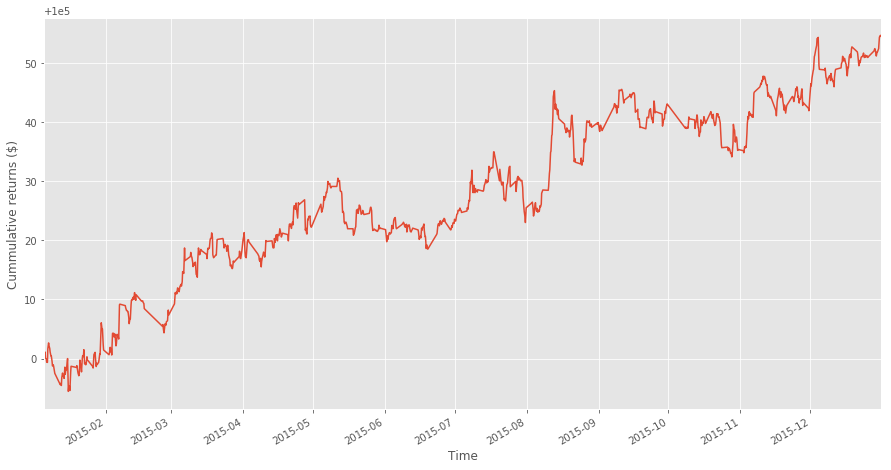

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting IC000=====================================
Creating ML_Models...


IndexError: index out of bounds

In [67]:
backtest_records, backtest_curves, df_bt = random_forest_run_backtests(rf_paras, 100000, 2, location, folder, rf_backtest_records)

In [90]:
location = glob.glob("C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data/*.csv")
folder = "C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data/testing_4h_signals/"
svm_paras = {   
                    # 参数组一：非指定机器学习算法的参数：
                    'n': [10],
                    'test_size': [1/6],
                    'rblnc_rs': [5],
                    'tts_rs': [5],
                    'svm_rs': [5],
                    
                    # 参数组二：特定机器学习算法的参数：
                    'C': [0.1, 1],
                    'gamma': ['auto']
                    
                    # n_estimators = [10, 50, 100]
                    # max_depth = [100]
                    # min_samples_split = [10]
                    }

svm_backtest_records = {'commodity':[],
                    'backtest':[],
#                     'n_estimators':[],
#                     'max_depth':[],
#                     'min_samples_split':[],

                    'rblnc_rs':[],
                    'tts_rs':[],
                    'svm_rs':[],

                    'C':[],
                    'gamma':[],

                    'sharpe':[],
                    'trades':[],
                    'accuracy':[]}




def svm_run_backtests(svm_paras, start_capital, trade_freq, location, folder, svm_backtest_records):
    
    location = location
    folder = folder
    
    # 计算总共的参数组合数量
    paras_number = 1
    for key in svm_paras.keys():
        key_len = len(svm_paras[key])
        paras_number = paras_number*key_len
    total_paras_sets = paras_number
    print ("总共参数组合有{}组".format(total_paras_sets))
    
    backtest_records = svm_backtest_records
    commodities = location
    start_capital = start_capital
    # for daily strategies: trade_freq = 1
    # for 4-hour strategies: trade_freq = 2
    trade_freq = trade_freq
    backtest_num = 0
    backtest_curves = pd.DataFrame([])
    # 计算总共的要跑的回测数量，这之中考虑到了参数组合+商品个数的数量
    total_backtests = total_paras_sets*len(commodities)

    # 非算法参数一：
    for n in svm_paras['n']:
        # 非算法参数二：
        for test_size in svm_paras['test_size']:
            # 非算法参数三：
            for rblnc_rs in svm_paras['rblnc_rs']:
                # 非算法参数四：
                for tts_rs in svm_paras['tts_rs']:
                    # 非算法参数五：
                    for svm_rs in svm_paras['svm_rs']:
                        
                        # 算法参数一：
                        for C in svm_paras['C']:
                            # 算法参数二：
                            for gamma in svm_paras['gamma']:
                                
                        
                        
                                # Loop 品种数目：
                                for file in location:

                                    ticker = file.split("\\",1)[1].split(".",1)[0].split("_",1)[0]
                                    print ("=====================================Start backtesting {}=====================================".format(ticker))

                                    model_cum_, y_pred_, acc_, df, X_val, y_val, mask_, data_returns_ = model_results(models.svm(c, g, svm_rs), rblnc_rs, tts_rs, start_capital)
                                    backtest_num = backtest_num + 1
                                    returns = model_cum_.pct_change().replace([np.inf, -np.inf], np.nan)
                                    returns_mean = returns.mean() 
                                    returns_stddev = returns.std()
                                    sharpe = returns_mean/returns_stddev*np.sqrt(trade_freq*252)
                                    signals_df = pd.DataFrame(y_pred_ ,index = model_cum_.index, columns=['signals'])
                                    signals_df['trades'] = signals_df.diff()
                                    num_of_trades = len(signals_df[signals_df['trades']!=0])

                                    backtest_records['commodity'].append(ticker)
                                    backtest_records['backtest'].append(backtest_num)
            #                             backtest_records['n_estimators'].append(n_e)
            #                             backtest_records['max_depth'].append(m_d)
            #                             backtest_records['min_samples_split'].append(m_s_s)
                                    backtest_records['rblnc_rs'].append(rs_1)
                                    backtest_records['tts_rs'].append(rs_2)
                                    backtest_records['svm_rs'].append(rs_3)

                                    backtest_records['C'].append(c)
                                    backtest_records['gamma'].append(gamma)

                                    backtest_records['sharpe'].append(sharpe)
                                    backtest_records['trades'].append(num_of_trades)
                                    backtest_records['accuracy'].append(acc_)
                                    print ("=============================================All Finished.==================================================")
                        #             print ("model_cum_: ", pd.DataFrame(model_cum_).head(3))
                                    backtest_curves = pd.concat([backtest_curves, pd.DataFrame(model_cum_)], axis=1)
                                    merged, master_pred_df = create_TB_signal_df(df, X_val, y_pred_, y_val, mask_, data_returns_, folder, "1_25_4h_{}_signals.csv".format(ticker), start_capital)

    new_cols = []
    for col_num in range(1, total_backtests+1):
        new_col = "bt{}".format(col_num)
        new_cols.append(new_col)
    backtest_curves.columns = new_cols

    backtest_curves.fillna(method='ffill', inplace=True)
    backtest_curves.plot(figsize=(16, 8))
    df_bt = pd.DataFrame(backtest_records)
    print (df_bt)

## 用之前分散的模块进行回测

=====================================Start backtesting au000=====================================
majority:0, length: 2319; minority:1, length: 2255


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
X length:  4638
X_val length:  1923
X_train length:  3865
X_test length:  773
-----------------------------------------------
y length:  4638
y_val length:  1923
y_train length: 3865
y_test length: 773
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 52.46 %
F1 Score: 0.3658
Area Under ROC Curve Score: 0.5246
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 50.18 %
F1 Score: 0.4101
Area Under ROC Curve Score: 0.4965
----------------------------------------------------


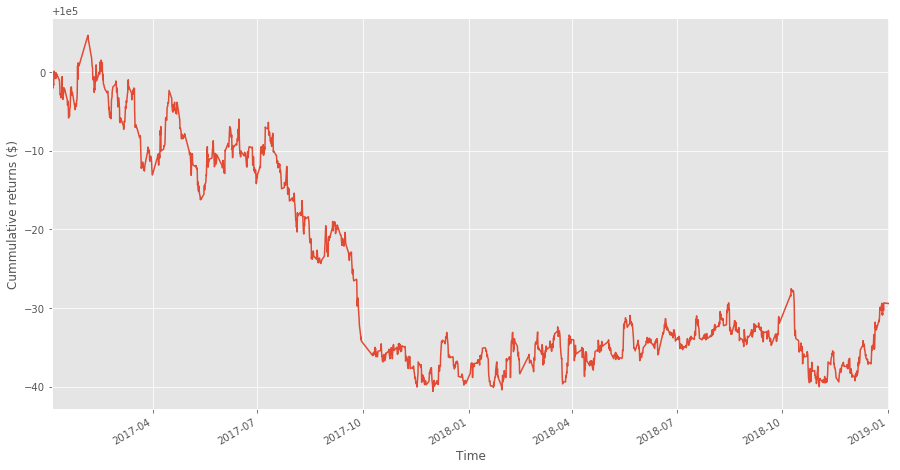

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting IC000=====================================
majority:1, length: 436; minority:0, length: 407
-----------------------------------------------
X length:  863
X_val length:  998
X_train length:  719
X_test length:  144
-----------------------------------------------
y length:  863
y_val length:  998
y_train length: 719
y_test length: 144
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 54.92 %
F1 Score: 0.5192
Area Under ROC Curve Score: 0.5492
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 52.10 %
F1 Score: 0.3210
Area Under ROC Curve Score: 0.5085
--------------------

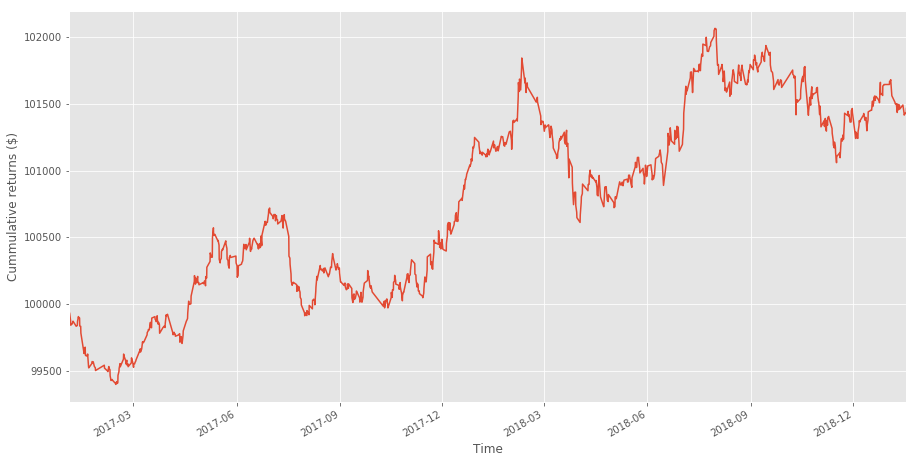

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting j9000=====================================
majority:0, length: 1949; minority:1, length: 1627
-----------------------------------------------
X length:  3891
X_val length:  1448
X_train length:  3242
X_test length:  649
-----------------------------------------------
y length:  3891
y_val length:  1448
y_train length: 3242
y_test length: 649
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 53.82 %
F1 Score: 0.4672
Area Under ROC Curve Score: 0.5383
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 51.45 %
F1 Score: 0.5025
Area Under ROC Curve Score: 0.5150
------------

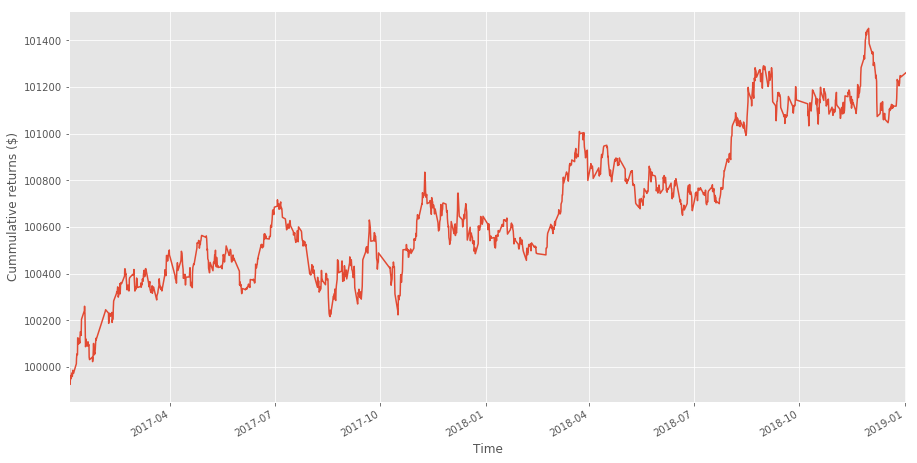

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting l9000=====================================
majority:0, length: 1498; minority:1, length: 1418
-----------------------------------------------
X length:  2996
X_val length:  999
X_train length:  2496
X_test length:  500
-----------------------------------------------
y length:  2996
y_val length:  999
y_train length: 2496
y_test length: 500
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 54.17 %
F1 Score: 0.5629
Area Under ROC Curve Score: 0.5417
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 51.95 %
F1 Score: 0.5303
Area Under ROC Curve Score: 0.5210
--------------

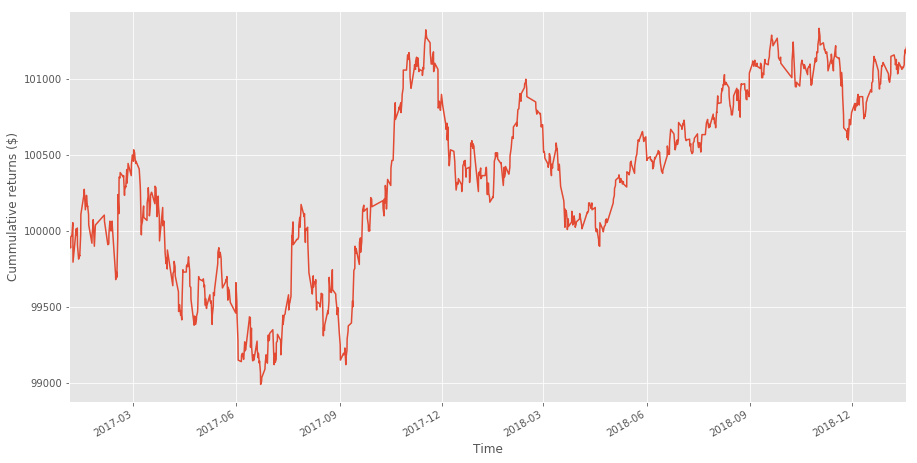

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting m9000=====================================
majority:0, length: 1805; minority:1, length: 1668
-----------------------------------------------
X length:  3610
X_val length:  1484
X_train length:  3008
X_test length:  602
-----------------------------------------------
y length:  3610
y_val length:  1484
y_train length: 3008
y_test length: 602
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 50.72 %
F1 Score: 0.5484
Area Under ROC Curve Score: 0.5072
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 50.07 %
F1 Score: 0.5729
Area Under ROC Curve Score: 0.5098
------------

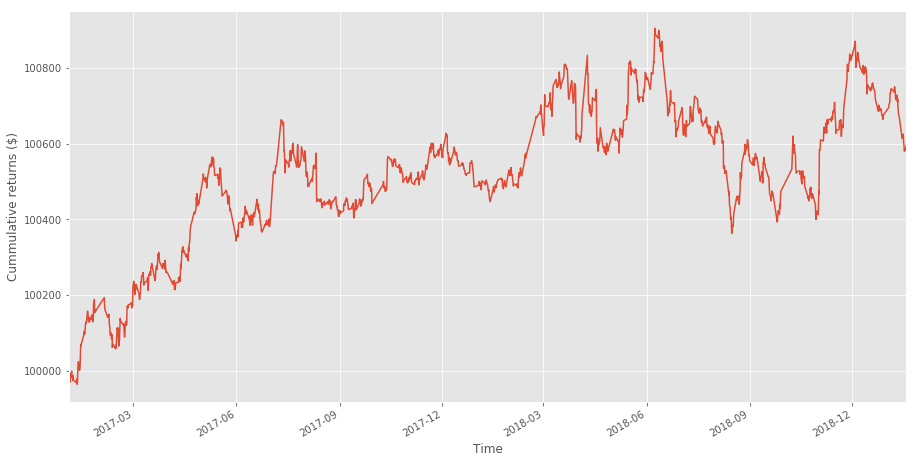

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting OI000=====================================
majority:0, length: 1274; minority:1, length: 1121
-----------------------------------------------
X length:  2541
X_val length:  1484
X_train length:  2117
X_test length:  424
-----------------------------------------------
y length:  2541
y_val length:  1484
y_train length: 2117
y_test length: 424
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 54.27 %
F1 Score: 0.5605
Area Under ROC Curve Score: 0.5427
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 51.21 %
F1 Score: 0.4806
Area Under ROC Curve Score: 0.5107
------------

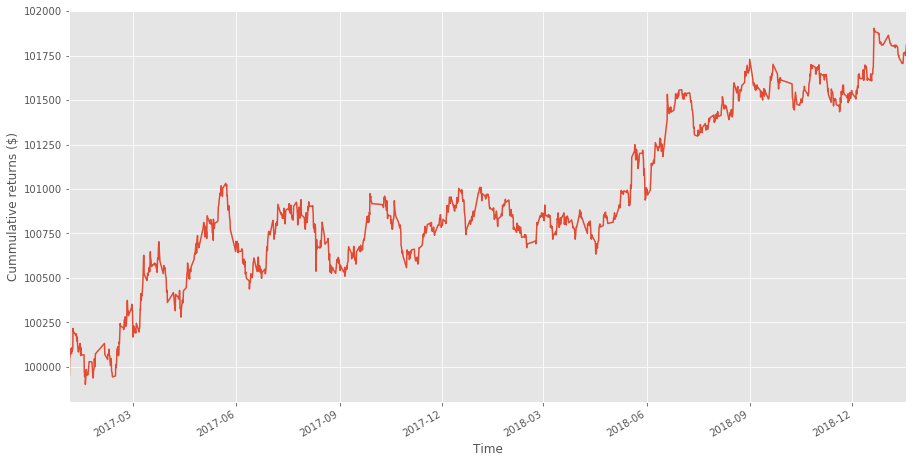

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting T9000=====================================
majority:1, length: 440; minority:0, length: 438
-----------------------------------------------
X length:  869
X_val length:  999
X_train length:  724
X_test length:  145
-----------------------------------------------
y length:  869
y_val length:  999
y_train length: 724
y_test length: 145
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 50.29 %
F1 Score: 0.6692
Area Under ROC Curve Score: 0.5000
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 49.85 %
F1 Score: 0.6644
Area Under ROC Curve Score: 0.4990
--------------------

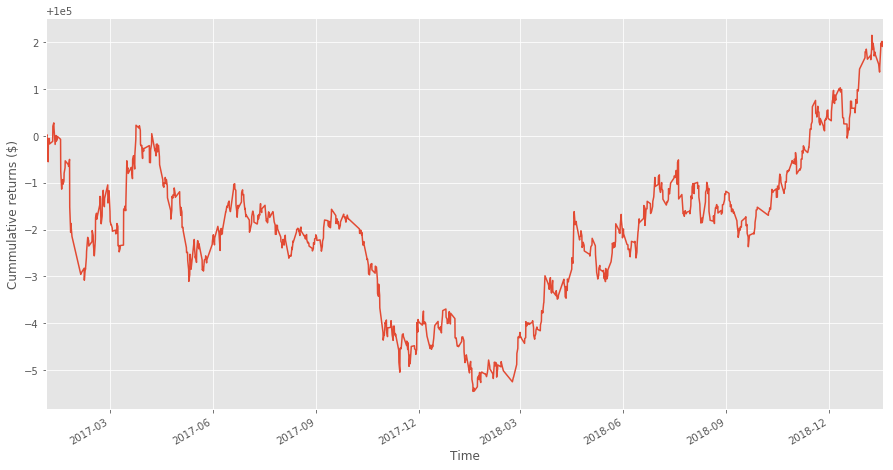

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting au000=====================================
majority:0, length: 2319; minority:1, length: 2255
-----------------------------------------------
X length:  4638
X_val length:  1923
X_train length:  3865
X_test length:  773
-----------------------------------------------
y length:  4638
y_val length:  1923
y_train length: 3865
y_test length: 773
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 54.05 %
F1 Score: 0.4397
Area Under ROC Curve Score: 0.5405
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 52.31 %
F1 Score: 0.5035
Area Under ROC Curve Score: 0.5224
------------

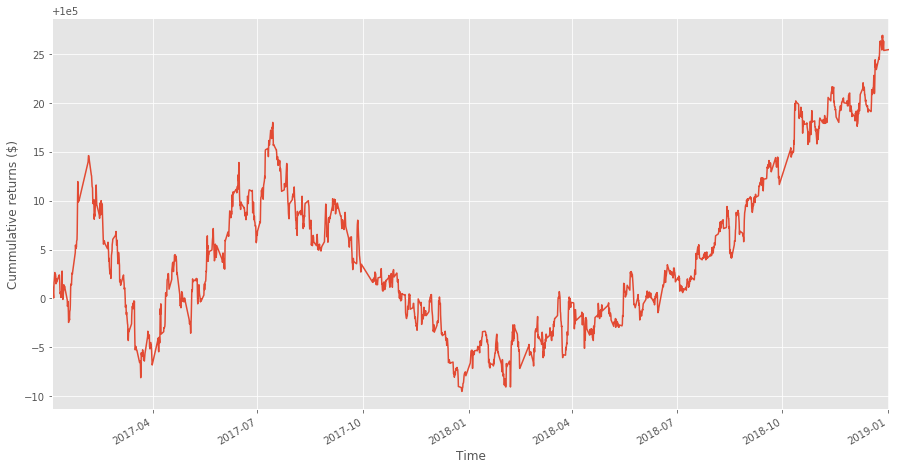

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting IC000=====================================
majority:1, length: 436; minority:0, length: 407
-----------------------------------------------
X length:  863
X_val length:  998
X_train length:  719
X_test length:  144
-----------------------------------------------
y length:  863
y_val length:  998
y_train length: 719
y_test length: 144
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 57.59 %
F1 Score: 0.6115
Area Under ROC Curve Score: 0.5760
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 50.90 %
F1 Score: 0.5000
Area Under ROC Curve Score: 0.5093
--------------------

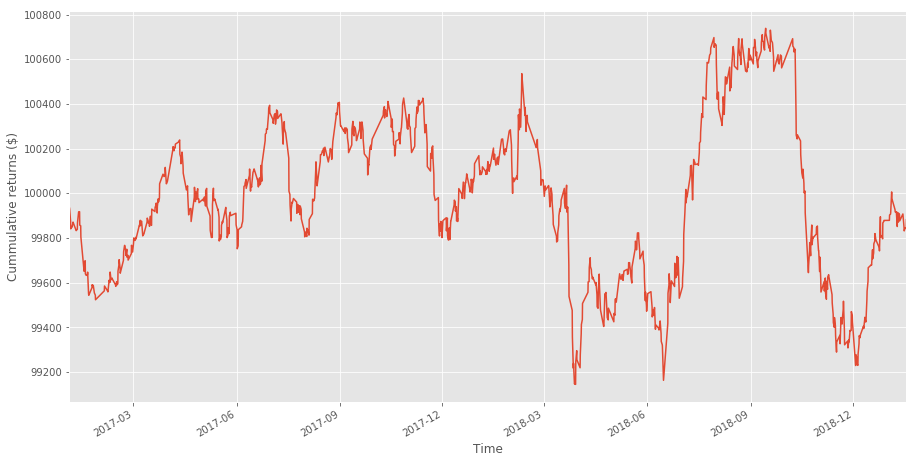

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting j9000=====================================
majority:0, length: 1949; minority:1, length: 1627
-----------------------------------------------
X length:  3891
X_val length:  1448
X_train length:  3242
X_test length:  649
-----------------------------------------------
y length:  3891
y_val length:  1448
y_train length: 3242
y_test length: 649
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 55.49 %
F1 Score: 0.4945
Area Under ROC Curve Score: 0.5550
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 52.42 %
F1 Score: 0.5258
Area Under ROC Curve Score: 0.5243
------------

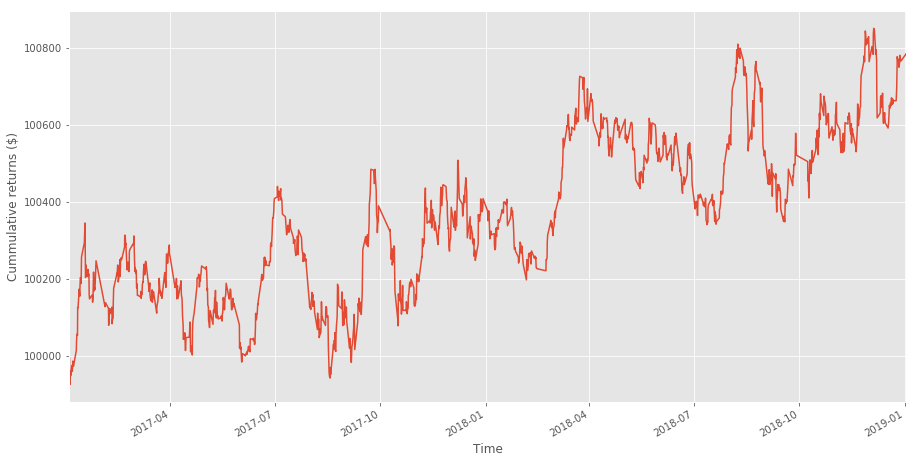

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting l9000=====================================
majority:0, length: 1498; minority:1, length: 1418
-----------------------------------------------
X length:  2996
X_val length:  999
X_train length:  2496
X_test length:  500
-----------------------------------------------
y length:  2996
y_val length:  999
y_train length: 2496
y_test length: 500
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 55.94 %
F1 Score: 0.5154
Area Under ROC Curve Score: 0.5594
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 52.85 %
F1 Score: 0.4714
Area Under ROC Curve Score: 0.5254
--------------

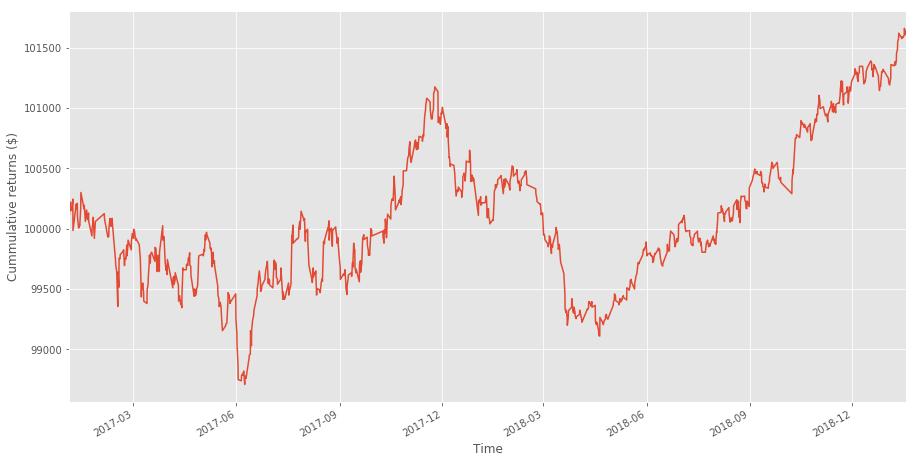

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting m9000=====================================
majority:0, length: 1805; minority:1, length: 1668
-----------------------------------------------
X length:  3610
X_val length:  1484
X_train length:  3008
X_test length:  602
-----------------------------------------------
y length:  3610
y_val length:  1484
y_train length: 3008
y_test length: 602
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 53.21 %
F1 Score: 0.5100
Area Under ROC Curve Score: 0.5321
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 50.88 %
F1 Score: 0.5163
Area Under ROC Curve Score: 0.5106
------------

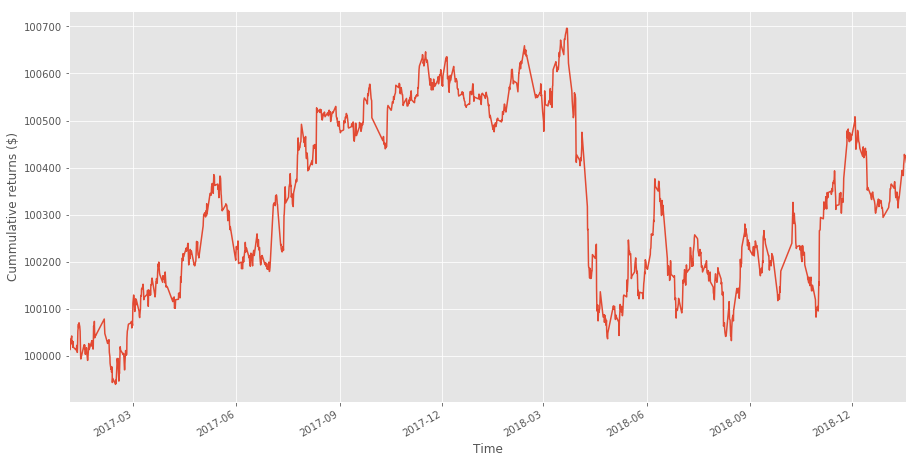

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting OI000=====================================
majority:0, length: 1274; minority:1, length: 1121
-----------------------------------------------
X length:  2541
X_val length:  1484
X_train length:  2117
X_test length:  424
-----------------------------------------------
y length:  2541
y_val length:  1484
y_train length: 2117
y_test length: 424
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 55.10 %
F1 Score: 0.5987
Area Under ROC Curve Score: 0.5508
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 50.67 %
F1 Score: 0.4903
Area Under ROC Curve Score: 0.5062
------------

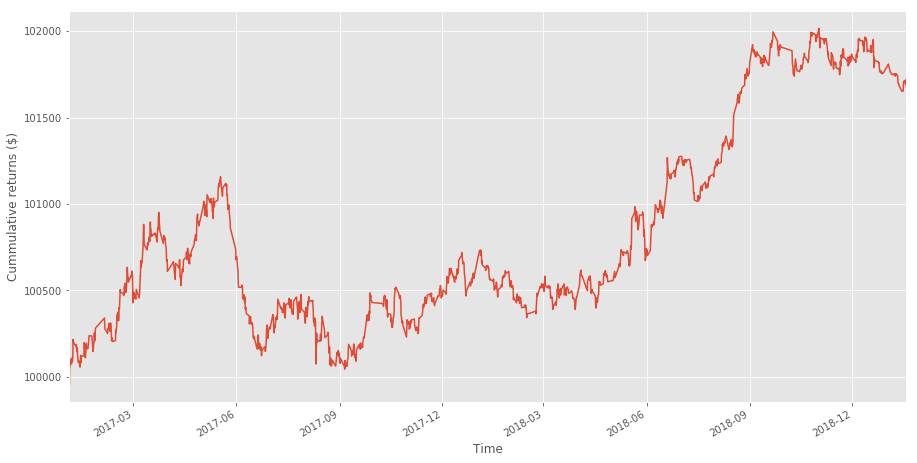

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting T9000=====================================
majority:1, length: 440; minority:0, length: 438
-----------------------------------------------
X length:  869
X_val length:  999
X_train length:  724
X_test length:  145
-----------------------------------------------
y length:  869
y_val length:  999
y_train length: 724
y_test length: 145
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 56.85 %
F1 Score: 0.6065
Area Under ROC Curve Score: 0.5679
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 49.55 %
F1 Score: 0.5410
Area Under ROC Curve Score: 0.4956
--------------------

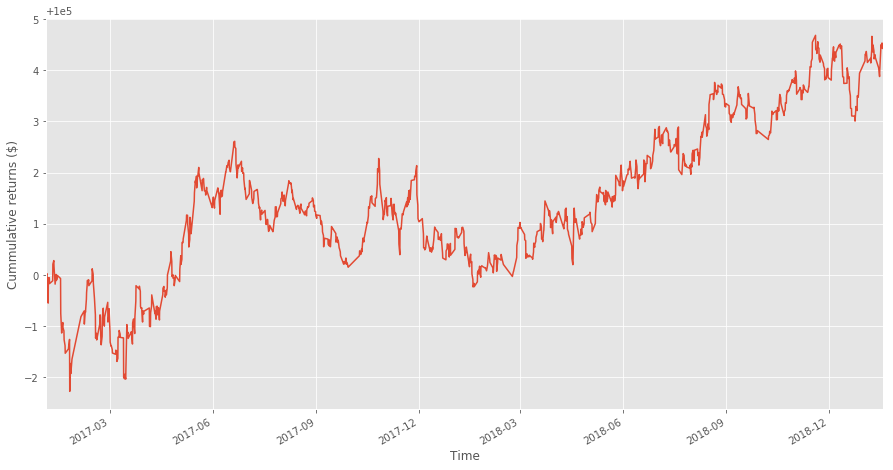

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
      C  accuracy  backtest commodity   gamma  rblnc_rs    sharpe  svm_rs  \
0   0.1  0.501820         1     au000  [auto]         5 -0.497991       5   
1   0.1  0.521042         2     IC000  [auto]         5  0.684517       5   
2   0.1  0.514503         3     j9000  [auto]         5  0.776801       5   
3   0.1  0.519520         4     l9000  [auto]         5  0.434285       5   
4   0.1  0.500674         5     m9000  [auto]         5  0.519065       5   
5   0.1  0.512129         6     OI000  [auto]         5  0.879292       5   
6   0.1  0.498498         7     T9000  [auto]         5  0.271454       5   
7   1.0  0.523141         8     au000  [auto]         5  0.427327       5   
8   1.0  0.509018         9     IC000  

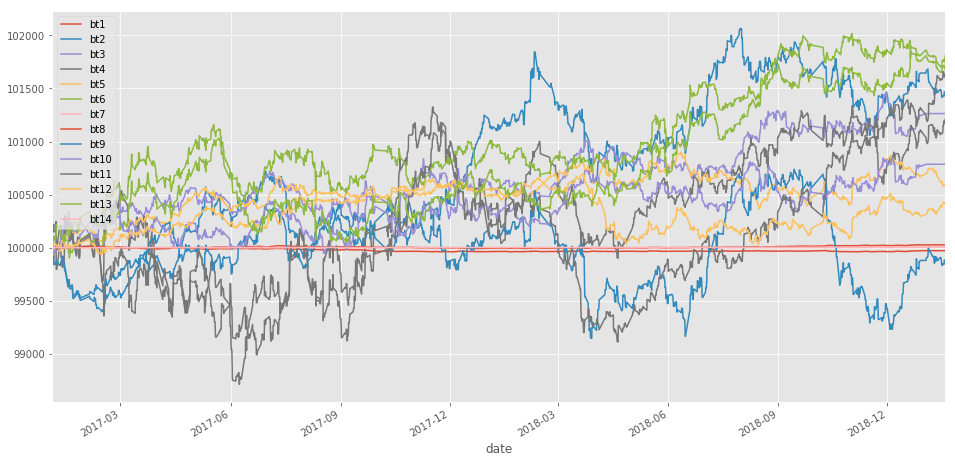

In [44]:
import glob

location = glob.glob("C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data/*.csv")
folder = "C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data/testing_4h_signals/"

backtest_records = {'commodity':[],
                    'backtest':[],
#                     'n_estimators':[],
#                     'max_depth':[],
#                     'min_samples_split':[],

                    'rblnc_rs':[],
                    'tts_rs':[],
                    'svm_rs':[],
                    
                    'C':[],
                    'gamma':[],
                    
                    'sharpe':[],
                    'trades':[],
                    'accuracy':[]}
# 参数组一：非指定机器学习算法的参数：
n = [10]
test_size = [1/6]
rblnc_rs = [5]
tts_rs = [5]
svm_rs = [5]

# 参数组二：特定机器学习算法的参数：

# C
para_1 = [0.1, 1]
# gamma
para_2 = ['auto']

# n_estimators = [10, 50, 100]
# max_depth = [100]
# min_samples_split = [10]

commodities = location

start_capital = 100000
# for daily strategies: trade_freq = 1
# for 4-hour strategies: trade_freq = 2
trade_freq = 2

backtest_num = 0
backtest_curves = pd.DataFrame([])
# 计算总共的参数组合数量
total_paras_sets = len(rblnc_rs)*len(tts_rs)*len(svm_rs)*len(C)*len(gamma)
# 计算总共的要跑的回测数量，这之中考虑到了参数组合+商品个数的数量
total_backtests = len(rblnc_rs)*len(tts_rs)*len(svm_rs)*len(C)*len(gamma)*len(commodities)
for 
# 参数一：
for rs_1 in rblnc_rs:
    # 参数二：
    for rs_2 in tts_rs:
        # 参数三：
        for rs_3 in svm_rs:
            # 参数四：
            for para in para_1:
                # 参数五：
                for para in para_2:
                    # Loop 品种：
                    for file in location:
                        
                        ticker = file.split("\\",1)[1].split(".",1)[0].split("_",1)[0]
                        print ("=====================================Start backtesting {}=====================================".format(ticker))
                        model_cum_, y_pred_, acc_, df, X_val, y_val, mask_, data_returns_ = model_results(models.svm(c, g, rs_3), rs_1, rs_2, start_capital)
                        backtest_num = backtest_num + 1
                        returns = model_cum_.pct_change().replace([np.inf, -np.inf], np.nan)
                        returns_mean = returns.mean() 
                        returns_stddev = returns.std()
                        sharpe = returns_mean/returns_stddev*np.sqrt(trade_freq*252)
                        signals_df = pd.DataFrame(y_pred_ ,index = model_cum_.index, columns=['signals'])
                        signals_df['trades'] = signals_df.diff()
                        num_of_trades = len(signals_df[signals_df['trades']!=0])

            #             print ("backtest: ", backtest_num)
            #             print ("rblnc_rs: ", rs_1)
            #             print ("tts_rs: ", rs_2)
            #             print ("RFC_rs: ", rs_3)
            #             print ("sharpe: ", sharpe)
            #             print ("trades: ", num_of_trades)
            #             print ("accuracy: ", acc_)
                        backtest_records['commodity'].append(ticker)
                        backtest_records['backtest'].append(backtest_num)
#                             backtest_records['n_estimators'].append(n_e)
#                             backtest_records['max_depth'].append(m_d)
#                             backtest_records['min_samples_split'].append(m_s_s)
                        backtest_records['rblnc_rs'].append(rs_1)
                        backtest_records['tts_rs'].append(rs_2)
                        backtest_records['svm_rs'].append(rs_3)

                        backtest_records['C'].append(c)
                        backtest_records['gamma'].append(gamma)

                        backtest_records['sharpe'].append(sharpe)
                        backtest_records['trades'].append(num_of_trades)
                        backtest_records['accuracy'].append(acc_)
                        print ("=============================================All Finished.==================================================")
            #             print ("model_cum_: ", pd.DataFrame(model_cum_).head(3))
                        backtest_curves = pd.concat([backtest_curves, pd.DataFrame(model_cum_)], axis=1)
                        merged, master_pred_df = create_TB_signal_df(df, X_val, y_pred_, y_val, mask_, data_returns_, folder, "1_25_4h_{}_signals.csv".format(ticker), start_capital)
                    
new_cols = []
for col_num in range(1, total_backtests+1):
    new_col = "bt{}".format(col_num)
    new_cols.append(new_col)
backtest_curves.columns = new_cols

backtest_curves.fillna(method='ffill', inplace=True)
backtest_curves.plot(figsize=(16, 8))
df_bt = pd.DataFrame(backtest_records)
print (df_bt)